In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.5 MB/s eta 0:00:00


In [ ]:
import random, time
from collections import deque, namedtuple

import gymnasium as gym
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

from tqdm.auto import tqdm

n_episodes = 120  # play 1000 games
eps = 0.85  # exploration rate, probability of choosing random action
eps_decay = 0.9975  # eps gets multiplied by this number each epoch...
min_eps = 0.1  # ...until this minimum eps is reached
gamma = 0.95  # discount
max_memory_size = 10000  # size of the replay memory
batch_size = 16  # batch size of the neural network training
min_length = 160  # minimum length of the replay memory for training, before it reached this length, no gradient updates happen
memory_parts = [
    "state",
    "action",
    "next_state",
    "reward",
    "done",
]  # nice names for the part of replay memory, otherweise the names are 0-5

Num GPUs Available:  0
Num CPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Learning A Model

In [ ]:
Memory = namedtuple("Memory", memory_parts)  # a single entry of the memory replay


class ReplayMemory:
    def __init__(self, max_length=None):
        self.max_length = max_length
        self.memory = deque(maxlen=max_length)

    def store(self, data):
        self.memory.append(data)

    def _sample(self, k):
        return random.sample(self.memory, k)

    def structured_sample(self, k):
        batch = self._sample(k)
        result = {}
        for i, part in enumerate(memory_parts):
            result[part] = np.array([row[i] for row in batch])

        return result

    def __len__(self):
        return len(self.memory)

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(4,)),  # Define input shape with Input layer
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(2, activation="linear"),  # 2 actions: go left or go right
    ]
)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [ ]:
env = gym.make("CartPole-v1")
replay_memory = ReplayMemory(max_length=max_memory_size)

for episode in tqdm(range(n_episodes)):  # tqdm makes a nice proress bar
    state, _ = env.reset()
    done = False

    while not done:
        if random.random() < eps:
            action = env.action_space.sample()  # random action
        else:
            action = model.predict(state[np.newaxis, :], verbose=False).argmax()  # best action according to the model

        next_state, reward, done, _, _ = env.step(action)
        memory = Memory(state, action, next_state, reward, done)
        replay_memory.store(memory)

        if len(replay_memory) >= min_length:
            batch = replay_memory.structured_sample(batch_size)  # get samples from the replay memory

            target_batch = batch["reward"] + gamma * model.predict(batch["next_state"], verbose=False).max(axis=1) * (
                1 - batch["done"]
            )  # R(s, a) + γ·maxₐ N(s') if not a terminal state, otherwise R(s, a)
            targets = model.predict(batch["state"], verbose=False)
            targets[
                range(batch_size), batch["action"]
            ] = target_batch  # set the target for the action that was done and leave the outputs of other 3 actions as they are

            model.fit(batch["state"], targets, verbose=False, batch_size=batch_size)  # train for one epoch

        state = next_state
    if episode % 100 == 0:
      save_path = '/content/drive/My Drive/my_QmodelB_{}iterations.keras'.format(episode)
      print (save_path)
      model.save(save_path)
    eps = max(min_eps, eps * eps_decay)
save_path = '/content/drive/My Drive/my_QmodelB_{}iterations.keras'.format(episode)
print (save_path)
model.save(save_path)

  0%|          | 0/120 [00:00<?, ?it/s]

/content/drive/My Drive/my_QmodelB_0iterations.keras
/content/drive/My Drive/my_QmodelB_100iterations.keras
/content/drive/My Drive/my_QmodelB_119iterations.keras


In [ ]:
eps_decay = 0.9775
min_eps = 0.01
eps = 0.1
for i in range(1000):
  eps = max(min_eps, eps * eps_decay)
  if (i % 10==0):
    print (i, eps)

print(eps)

0 0.09775
10 0.0778546267131019
20 0.06200862302441372
30 0.04938780765789448
40 0.03933574761518005
50 0.03132961582670723
60 0.02495299790540339
70 0.019874233629647003
80 0.015829166654170272
90 0.012607405228029738
100 0.01004137931303391
110 0.01
120 0.01
130 0.01
140 0.01
150 0.01
160 0.01
170 0.01
180 0.01
190 0.01
200 0.01
210 0.01
220 0.01
230 0.01
240 0.01
250 0.01
260 0.01
270 0.01
280 0.01
290 0.01
300 0.01
310 0.01
320 0.01
330 0.01
340 0.01
350 0.01
360 0.01
370 0.01
380 0.01
390 0.01
400 0.01
410 0.01
420 0.01
430 0.01
440 0.01
450 0.01
460 0.01
470 0.01
480 0.01
490 0.01
500 0.01
510 0.01
520 0.01
530 0.01
540 0.01
550 0.01
560 0.01
570 0.01
580 0.01
590 0.01
600 0.01
610 0.01
620 0.01
630 0.01
640 0.01
650 0.01
660 0.01
670 0.01
680 0.01
690 0.01
700 0.01
710 0.01
720 0.01
730 0.01
740 0.01
750 0.01
760 0.01
770 0.01
780 0.01
790 0.01
800 0.01
810 0.01
820 0.01
830 0.01
840 0.01
850 0.01
860 0.01
870 0.01
880 0.01
890 0.01
900 0.01
910 0.01
920 0.01
930 0.01
940 0.01
9

# Test Learned Models

In [ ]:
## Choose Model
version = 1

models = [(0, '13SHwUL0d59cbUtthBKgf-Y6g_5iVe0QQ'), (119, '1-4NHotN1Edao-2ZSB4_-s_NFqDH_Syli')]

!gdown {models[version][1]}
save_path=f'my_QmodelB_{models[version][0]}iterations.keras'
print(save_path)

Downloading...
From: https://drive.google.com/uc?id=1-4NHotN1Edao-2ZSB4_-s_NFqDH_Syli
To: /content/my_QmodelB_119iterations.keras
100% 147k/147k [00:00<00:00, 5.53MB/s]
my_QmodelB_119iterations.keras


In [ ]:
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf

from tensorflow.keras.models import load_model

model = load_model(save_path, compile=False)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

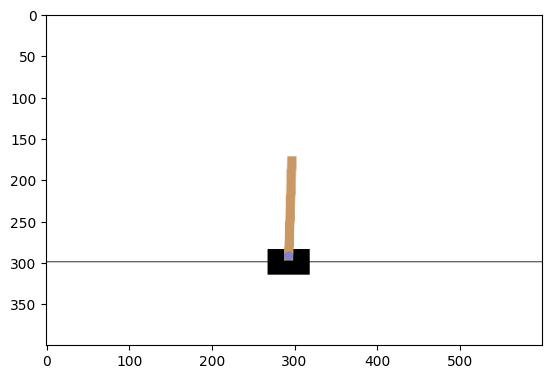

action=0, total_reward=1.0


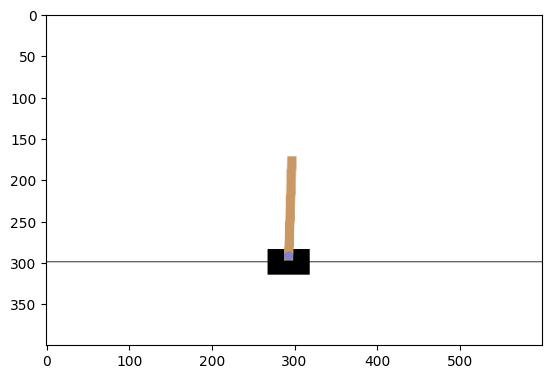

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
done = False
total_reward = 0
state_image=env.render()
plt.imshow(state_image)
plt.show()

state_image=env.render()
action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
state, reward, done, _, _ = env.step(action)
total_reward += reward
print (f"{action=}, {total_reward=}")
state_image=env.render()
plt.imshow(state_image)
plt.show()

In [ ]:
env = gym.make("CartPole-v1", render_mode="human")

state, _ = env.reset()
done = False
total_reward = 0

while not done and total_reward < 500:  # force end the game after 500 time steps because the model is too good!
    env.render()
    action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
    state, reward, done, _, _ = env.step(action)
    total_reward += reward

env.close()
print (f"{total_reward=}")

total_reward=99.0


In [ ]:
env.close()


To begin with, I decided to significantly reduce the epochs to 120 since 1000 was too huge and it was taking way too long for my computer to run. With a size of 120, I still found it to be resonable to identify the changes within the algorithm.

**Model Definition**

Epochs: 120

Initial Epsilon: 0.85

Gamma: 0.88

The initial model was trained using the above parameters and achieved a reward of 152. The focus was then placed on adjusting specific parameters like epsilon decay and gamma to observe their impact on the performance.

**Epsilon Decay Adjustments**

Initial Epsilon Decay: 0.75 → Reward: 152

Changed Epsilon Decay: 0.1 → Reward: 157

Observation: A slight improvement in the reward was noted when reducing epsilon decay, suggesting that the model benefited from a more aggressive exploration-exploitation balance in this case.
Further Adjustment:

Epsilon decay reduced from 0.9775 to 0.5200 → Reward: 150

Observation: This change slightly decreased the reward, indicating that this level of epsilon decay did not enhance model performance compared to earlier configurations.

**Gamma Adjustments**

Gamma Increased: 0.88 → 0.95 → Reward: 70

Observation: Surprisingly, increasing gamma to 0.95 led to a significant drop in the reward. This suggests that the model may have overvalued future rewards, causing suboptimal actions.

Gamma Reduced: 0.95 → 0.5 → Reward: 99

Observation: Lowering the gamma improved performance slightly but did not restore it to earlier levels, showing the importance of balancing the discount factor for future rewards.


**Discussion Frozen lake**

When comparing these experiments to the Frozen Lake environment, the impact of exploration strategies and hyperparameter tuning becomes even more apparent. In Frozen Lake, a sparse reward structure and slippery surface make it especially challenging to balance exploration and exploitation effectively. The model-free nature of Q-Learning, which learns directly from experiences without needing a model of the environment, proves to be flexible but sensitive to hyperparameters such as epsilon and gamma.

In conclusion, while Q-Learning doesn’t match the theoretical precision of Value Iteration, its adaptability makes it highly useful for real-world problems like Frozen Lake, where a complete model of the environment is unavailable or impractical. By fine-tuning hyperparameters such as epsilon decay and gamma, you can significantly impact the agent's ability to learn effectively in uncertain, dynamic environments.



